### Data loading and analysis notebook for Allio Bullet R1 V2 roast data https://aillio.com/
**by Ryan @f.w.Bennies https://www.instagram.com/f.w.bennies/**

<img src="images/allRoastsPlt.png" alt="friends" width="270"/> <img src="images/bulletRoastingEDA.png" alt="friends" width="210"/><img src="images/friendshipsign.png" alt="friends" width="210"/>


#### Objectives
 Automaticaly load, serialize, and combine data from .json files. Then clean up unwanted data (non-standard batches)
 Split into curve and point data, create a few new features
 Summarize and display data (EDA) to enable data driven decisions in planning and real-time roasting

#### Nice to haves:
 impute data (with confidence) rather than remove missing data
 generate additional new features
 incorporate bean density

#### Excluding
 assocation for brewing techniques or results such as taste and aroma
 quantified color changes

*Note: If your RoastTime isn't installed in the default MacOS location, edit 'base_path' (lines ~18-19)*

*Built for my bullet (hardware version) purchased in July 2020 - noteworthy because the data structure of the .json files have changed over time which requires some merges or gap fixes.*

In [1]:
#################################################
## open each .json in folder and append to df  ##
#################################################
import os
from pathlib import Path
import json
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import scipy.stats as stats
pd.set_option('display.max_columns', 55)
plt.style.use('seaborn-colorblind')

# Load from roasTime repository on macOS
home = os.path.expanduser('~')
base_path = os.path.join(home, 'Library/Application Support/roast-time/roasts')
##  IF you have a specific set of roast profiles in another folder, uncomment the below
# base_path = Path('/data')

df = pd.DataFrame()

for entry in os.listdir(base_path):
    full_path =  Path('%s/%s' % (base_path, entry))
    with full_path.open() as f:
        data = json.loads(f.read())
        df_load = pd.json_normalize(data)
    df = pd.concat([df,df_load], ignore_index=True)

# Export the raw DataFrame to a .csv file just for the record
#create subfolder
subfolder = 'csvExports/'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

df.to_csv(subfolder + f"raw_bullet-roasting_df.csv", index=False)

#############################
##  First basic clean up   ##
#############################

# Sort by time and remove rows with missing roastName
df.sort_values(by='dateTime', inplace=True)
df.dropna(subset=['roastName'], inplace=True)

# Filter dataframe to only your User ID

choiceUserID = '73009f59-2d2e-4215-b6ff-961946ee0b80' ## enter specific userID (extracted from .json roast file, or RoastWorld web address)
df = df.query('userId == @choiceUserID and isFork != 1.0')

# Define list of unused data
other_meta = ['userId', 'isFork', 'serialNumber', 'IRSensor', 'inventory.nextGreenWeight',
              'inventory.previousGreenWeight', 'inventory.changeInGreenWeight', 'isPrivate',
             'slug', 'updated_at', 'updatedAt', 'hardware']

# Drop the extra data
df.drop(other_meta, axis=1, inplace = True)

# shift column 'Name' to first position
first_column = df.pop('roastName')
df.insert(0, 'roastName', first_column)

display (df)

,roastName,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,exitTemperature,preheatTemperature,roastStartIndex,roastEndIndex,totalRoastTime,indexFirstCrackStart,indexFirstCrackEnd,indexSecondCrackStart,indexSecondCrackEnd,indexYellowingStart,weightGreen,weightRoasted,roastNumber,sampleRate,firmware,missingSeconds,rorPreheat,uid,dateTime,ambient,humidity,beanId,softwareVersion,firmwareVersion,actions.actionTempList,actions.actionTimeList,guid,number,rating,comments,ambientTemp,roomHumidity,annotationComments,roastDegree,recipeID
7,First Post-seasoning,125.9,187.6,237.7,204.6,"[125.9, 126.1, 126.2, 126.3, 126.4, 126.5, 126...","[237.7, 237.6, 237.9, 238, 237.3, 25, 25, 25, ...","[18.7, 17.6, 16.1, 14.3, 12.8, 11, 7, -0.9, -1...",[],"[-55.7, -52.2, -60.4, -60.4, -60.4, -52.2, -60...",240,0,1099,547,880,0,0,0,756,370,0,8,2,562,[],NaN,56c8ea68-dca0-4ec6-8934-e469744b425d,1595642007716,NaN,NaN,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",56c8ea68-dca0-4ec6-8934-e469744b425d,983.0,2,First real attempt after seasoning. Several sm...,78,90,NaN,NaN,NaN
116,2nd Ethopia Extended Dev,150.1,189.8,244.9,207.6,"[150.1, 150.1, 150.1, 150.1, 150.2, 150.2, 150...","[244.9, 245.1, 244.8, 244.6, 243.9, 25, 25, 25...","[2.6, 2.8, 2.6, 2.2, 1.2, -0.4, -4.4, -11.5, -...",[],"[-52.2, -55.7, -52.2, -55.7, -52.2, -52.2, -60...",245,0,971,483,760,0,0,0,406,380,336,9,2,562,[],NaN,a455d0a0-23a7-4425-9ce5-950fd97e238e,1595983767878,0,50,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",a455d0a0-23a7-4425-9ce5-950fd97e238e,984.0,2,Better results to drop temp by increasing fan ...,78,50,NaN,NaN,NaN
95,First BBP attempt - CItyish,147.8,202.6,245.1,216.1,"[147.8, 148, 148.1, 148.3, 148.4, 148.5, 148.6...","[245.1, 245.7, 245.6, 245.1, 245, 25, 25, 25, ...","[19.7, 19, 18.7, 18.2, 16.6, 14.4, 11.3, 5.9, ...",[],"[-52.2, -60.4, -52.2, -52.2, -52.2, -49.4, -55...",245,0,1031,513,838,0,0,0,422,490,425,10,2,562,[],NaN,f9561e80-21de-4d2c-9258-eff0071b8c05,1596160358079,NaN,NaN,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",f9561e80-21de-4d2c-9258-eff0071b8c05,986.0,2,First BBP PH try. PH to 260 9 mins + 2 min hol...,NaN,NaN,NaN,NaN,NaN
9,Ethiopia #4 w/ marcel,150.0,199.8,245.3,208.6,"[150, 150.1, 150.2, 150.3, 150.5, 150.6, 150.6...","[245.3, 244.9, 244.9, 243.7, 243.5, 25, 25, 25...","[16.6, 15.8, 15.8, 15.4, 14.5, 6.9, 6.9, -0.8,...",[],"[-52.2, -52.2, -52.2, -55.7, -55.7, -52.2, -52...",245,0,1125,560,872,0,0,0,448,490,0,12,2,562,[],NaN,965db6e7-37ff-4504-a616-1bd64f50723f,1596417079393,NaN,NaN,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",965db6e7-37ff-4504-a616-1bd64f50723f,988.0,2,Tried to use an increased fan speed to mitgate...,71,75,NaN,NaN,NaN
114,Ethiopian 5th - Hot Start,158.7,198.9,247.3,211.0,"[158.7, 158.8, 159, 159.2, 159.3, 159.5, 159.5...","[247.3, 247.2, 247, 246.5, 245.3, 25, 25, 25, ...","[21.8, 21.5, 20.7, 19.9, 18.7, 14.8, 7.4, -3.6...",[],"[-52.2, -52.2, -49.4, -55.7, -52.2, -49.4, -49...",245,0,1037,516,780,0,0,0,402,490,427,13,2,562,[],NaN,a013107d-595b-495b-bc93-17310915df38,1596498641198,NaN,NaN,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",a013107d-595b-495b-bc93-17310915df38,990.0,2,"Started with a long 35mins PH to 260, then dro...",80,52,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,#126 - Ethiopia Crown Jewels Natural Wengo,162.8,205.2,246.6,210.5,"[162.8, 162.9, 162.9, 163, 163, 163.1, 163.1, ...","[246.6, 246.3, 246.3, 246.5, 246, 25, 25, 25, ...","[8.3, 8.2, 7.7, 6.9, 5.5, 4.4, 0.1, -6.9, -16....","[12, 0, -9, 0, 6, -15, -6630, 0

In [2]:
## This is where I may put a LOAD from the outside .py file

In [3]:
#############################
# Clean up and Enrich data  #
#############################
try:
    # change dtypes
    dtype_cols = ['weightGreen','weightRoasted','ambient', 'humidity', 'ambientTemp','roomHumidity']
    df[dtype_cols] = df[dtype_cols].apply(pd.to_numeric, errors='coerce')

    # combine RT2 ambientTemp and roomHumidity with RT3 ambient and humidity (note I am using ambient F)
    ambientMeasurement = 'F'  #or C

    df.loc[df['ambient'].isna(), 'ambient'] = df['ambientTemp'].astype(float)
    df.loc[df['humidity'].isna(), 'humidity'] = df['roomHumidity'].astype(float)
    df.drop(columns=['ambientTemp', 'roomHumidity','exitTemperature'], inplace =  True)  #dropping old environmental data and exitTemp

    # convert dateTime
    df['dateTime'] = pd.to_datetime(df['dateTime'], unit='ms')

    ###OPPORTUNITY to impute ambient temp where missing##
    df.ambient.replace(to_replace = 0.0, value = np.nan, inplace = True) # some case of temp actually being 0.0 C or F will be excluded, but needed to remove outliers
except KeyError:
    print("Key Error Exception due to repeated runs and 'old' columns no longer exist.  Skipping execution.")



# Calculate -> weight lost percent = 100 * (green - roasted)/ green #   PLUS OTHERS
df['weightLostPercent'] = 100 * (df['weightGreen'] - df['weightRoasted']) / df['weightGreen']
df.loc[df['weightLostPercent'] > 25, 'weightLostPercent'] = np.nan  ## Future -> understand if there is a better cut off than 25

# Fix low and high pre-heat errors (replace drumChargeTemperature w/ PH temp when z value > 3)
# May want to edit raw json file if you still have bad preheat temps
#df['drumChargeTemperature'].where(abs(stats.zscore(df.drumChargeTemperature-df.preheatTemperature)) < 3,
#                                  df['preheatTemperature'], inplace = True)

# calulate difference of beanDropTemp and beanChargeTemp (not ITBS, this should relative)   # maybe
df['Drop-ChargeDeltaTemp'] = df['beanDropTemperature'] - df['beanChargeTemperature']

# remove instances where FC was not picked or picked late 
## Would be better to impute FC values in the future
df.loc[(df['indexFirstCrackStart'] > 2400) | (df['indexFirstCrackStart'] == 0), 'indexFirstCrackStart'] = np.nan
df.loc[df['weightRoasted'] < 10, 'weightRoasted'] = np.nan
df.loc[df['weightLostPercent'] > 50, 'weightLostPercent'] = np.nan
    
display (df.head(3))
display (df.tail(3))

,roastName,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,preheatTemperature,roastStartIndex,roastEndIndex,totalRoastTime,indexFirstCrackStart,indexFirstCrackEnd,indexSecondCrackStart,indexSecondCrackEnd,indexYellowingStart,weightGreen,weightRoasted,roastNumber,sampleRate,firmware,missingSeconds,rorPreheat,uid,dateTime,ambient,humidity,beanId,softwareVersion,firmwareVersion,actions.actionTempList,actions.actionTimeList,guid,number,rating,comments,annotationComments,roastDegree,recipeID,weightLostPercent,Drop-ChargeDeltaTemp
7,First Post-seasoning,125.9,187.6,237.7,204.6,"[125.9, 126.1, 126.2, 126.3, 126.4, 126.5, 126...","[237.7, 237.6, 237.9, 238, 237.3, 25, 25, 25, ...","[18.7, 17.6, 16.1, 14.3, 12.8, 11, 7, -0.9, -1...",[],240,0,1099,547,880.0,0,0,0,756,370.0,NaN,8,2,562,[],NaN,56c8ea68-dca0-4ec6-8934-e469744b425d,2020-07-25 01:53:27.716,78.0,90.0,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",56c8ea68-dca0-4ec6-8934-e469744b425d,983.0,2,First real attempt after seasoning. Several sm...,NaN,NaN,NaN,NaN,61.7
116,2nd Ethopia Extended Dev,150.1,189.8,244.9,207.6,"[150.1, 150.1, 150.1, 150.1, 150.2, 150.2, 150...","[244.9, 245.1, 244.8, 244.6, 243.9, 25, 25, 25...","[2.6, 2.8, 2.6, 2.2, 1.2, -0.4, -4.4, -11.5, -...",[],245,0,971,483,760.0,0,0,0,406,380.0,336.0,9,2,562,[],NaN,a455d0a0-23a7-4425-9ce5-950fd97e238e,2020-07-29 00:49:27.878,NaN,50.0,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",a455d0a0-23a7-4425-9ce5-950fd97e238e,984.0,2,Better results to drop temp by increasing fan ...,NaN,NaN,NaN,11.578947,39.7
95,First BBP attempt - CItyish,147.8,202.6,245.1,216.1,"[147.8, 148, 148.1, 148.3, 148.4, 148.5, 148.6...","[245.1, 245.7, 245.6, 245.1, 245, 25, 25, 25, ...","[19.7, 19, 18.7, 18.2, 16.6, 14.4, 11.3, 5.9, ...",[],245,0,1031,513,838.0,0,0,0,422,490.0,425.0,10,2,562,[],NaN,f9561e80-21de-4d2c-9258-eff0071b8c05,2020-07-31 01:52:38.079,NaN,NaN,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,[],"[{'index': 6, 'value': 7, 'ctrlType': 0}, {'in...",f9561e80-21de-4d2c-9258-eff0071b8c05,986.0,2,First BBP PH try. PH to 260 9 mins + 2 min hol...,NaN,NaN,NaN,13.265306,54.8


,roastName,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,preheatTemperature,roastStartIndex,roastEndIndex,totalRoastTime,indexFirstCrackStart,indexFirstCrackEnd,indexSecondCrackStart,indexSecondCrackEnd,indexYellowingStart,weightGreen,weightRoasted,roastNumber,sampleRate,firmware,missingSeconds,rorPreheat,uid,dateTime,ambient,humidity,beanId,softwareVersion,firmwareVersion,actions.actionTempList,actions.actionTimeList,guid,number,rating,comments,annotationComments,roastDegree,recipeID,weightLostPercent,Drop-ChargeDeltaTemp
21,#128 - Columbia Santa Barbra Natural - Power o...,154.2,202.2,240.9,210.8,"[154.2, 154.3, 154.4, 154.6, 154.7, 155.1, 155...","[240.9, 241.1, 241.4, 241.7, 241.7, 25, 25, 25...","[9.3, 11, 13, 14.9, 15.9, 13, 5.8, -5.4, -20.2...","[0, 0, 6, 9, 9, 0.1, 0.1, 0.9, 0.9, 3.5, 3.5, ...",240,0,1136,566,978.0,0,0,0,508,600.0,518.0,148,2,605,[],197.2,jsYE8LJ3CW4vEuGgVC-GX,2023-05-03 02:31:28.541,30.0,46.5,GTx5n8nsF613ejcKowm1U,3.4.1,605.0,[],"[{'ctrlType': 0, 'index': 6, 'value': 7}, {'ct...",jsYE8LJ3CW4vEuGgVC-GX,NaN,0,Trying this as an experiment against the fan o...,NaN,NaN,NaN,13.666667,48.0
63,#129 Columbia Natural Mostly fan 245,159.0,200.8,245.9,209.4,"[159, 159.2, 159.4, 159.6, 159.8, 160.1, 160, ...","[245.9, 246, 246.1, 245.4, 244.2, 25, 25, 25, ...","[25.5, 25.1, 24.9, 24.8, 23.4, 10.6, -1.4, -16...","[0, 0, 3, 3, -21, -36, -6576, 0.5, 0.5, 2.4, 2...",245,0,1117,556,1022.0,0,0,0,562,698.7,612.3,150,2,605,[],28.4,_DYAWnadQBCEtsQ-EAnoc,2023-05-12 01:04:32.758,32.6,40.0,NaN,3.4.1,605.0,[],"[{'ctrlType': 0, 'index': 6, 'value': 2}, {'ct...",NaN,NaN,NaN,Pretty decent roast. at 700g I only went 5 deg...,NaN,NaN,NaN,12.365822,41.8
89,#130 - Ethiopia Crown Jewel,166.7,199.4,249.1,206.9,"[166.7, 166.7, 166.8, 166.8, 166.8, 166.9, 166...","[249.1, 249, 249.2, 249.1, 249.3, 25, 25, 25, ...","[1.7, 2.4, 4, 5.2, 5.9, 5.8, 4.8, 1.1, -5.3, -...","[6, 3, -3, 6, -3, 6, -6729, 0.2, 0.2, 1.6, 1.6...",250,0,974,485,836.0,0,0,0,442,650.0,579.7,150,2,605,[],28.4,BB2prBiatDe4bF23ocNKi,2023-05-12 01:38:17.981,35.5,41.0,NaN,3.4.1,605.0,[],"[{'ctrlType': 0, 'index': 6, 'value': 2}, {'ct...",NaN,NaN,NaN,Went in hot and coasted or controlled it prett...,NaN,NaN,NaN,10.815385,32.7


In [4]:
######################################################
# deconstruct temp curves from lists to new curve_df #
######################################################
## data for temp and derivative curve of each  is in a single cell as a list ###
# For each roast (row) extract list of each curve data into a new DF and transpose,
# add indexTime unique to each roast, add curve, concatenate to buddle all roasts curves.

temp_curve_df = pd.DataFrame()
curve_df = pd.DataFrame()
for index, row in df.iterrows():
        temp_curve_df = pd.DataFrame([pd.Series(row['beanTemperature'], name = 'beanTemperature', dtype='float64'), 
                                      pd.Series(row['drumTemperature'], name = 'drumTemperature', dtype='float64'),
                                      pd.Series(row['beanDerivative'], name = 'beanDerivative', dtype='float64'),
                                      pd.Series(row['ibtsDerivative'], name = 'ibtsDerivative', dtype='float64')]).T
        temp_curve_df['roastName'] = row['roastName']
        temp_curve_df['indexTime'] = temp_curve_df.index
        temp_curve_df['softwareVersion'] = row['softwareVersion']
        curve_df = pd.concat([curve_df, temp_curve_df],ignore_index = True) #update from #curve_df = curve_df.append(temp_curve_df,ignore_index = True) 1/23/24 for append depreciation

# Calculate second derivative        
# first pass at 2nd Derivative, review and see if it should be smoothed
curve_df['ibts2ndDerivative'] = curve_df.groupby('roastName')['ibtsDerivative'].apply(lambda x:x.diff())

#TO DO - Create 1stDerivative for roasts (.groupby('roastName')) with NaN itbsDerivative before Allio started adding it

curve_df.fillna(value=np.nan, inplace=True)
#display (curve_df.head(3))
display (curve_df.tail(3))

,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,roastName,indexTime,softwareVersion,ibts2ndDerivative
153021,199.3,206.9,5.5,-0.6,#130 - Ethiopia Crown Jewel,971,3.4.1,0.2
153022,199.3,206.9,5.9,-0.6,#130 - Ethiopia Crown Jewel,972,3.4.1,0.0
153023,199.4,206.9,5.8,-0.1,#130 - Ethiopia Crown Jewel,973,3.4.1,0.5


In [5]:
########################################################
## Create df of point sets (single entry per profile) ##
########################################################
pd.set_option('display.max_columns', 500)

point_list = ['roastName','dateTime', 'beanChargeTemperature', 'beanDropTemperature', 'drumChargeTemperature',
           'drumDropTemperature', 'preheatTemperature', 'roastStartIndex', 'roastEndIndex',
           'weightGreen', 'weightRoasted', 'weightLostPercent','ambient', 'humidity','Drop-ChargeDeltaTemp',
           'totalRoastTime', 'indexFirstCrackStart', 'indexFirstCrackEnd', 'indexYellowingStart',
           'comments','roastNumber', 'firmware', 'missingSeconds',
           'rating', 'beanId' ]
point_df = pd.DataFrame(df, columns = point_list).reset_index()
point_df.drop(columns='index', inplace = True)
point_df.indexYellowingStart = point_df.indexYellowingStart.fillna(value=np.nan)
point_df['totalRoastTime'] = point_df.totalRoastTime/60  # apparently totalRoastTime is counted in seconds not index steps
#display (point_df.tail(15))


In [6]:
### Enrich Point_DF ###
#######################

# TO DO:
# (MAX ROR) [Done = TP, Yellow, FC, weight lost]
# next (drying-malliard-dev times, and mean ROR between points & phases)
# then (ROR and 2nd Derivitive average values  in each phase or between key points (185, 190))

################################################################################################
##  Find turning point index and index at 165 deg bean Temp (alt to inconsistently picked YP) ##
################################################################################################
sampleRate = 2
roastName_df = curve_df.groupby(['roastName']) 
for name, group in roastName_df:
    minBT = group.beanTemperature.min()  ### Get to 0 ROR indexTime (Turning Point) via first occurance of minBT
    for i,row in group.iterrows():
        if row.beanTemperature == minBT and row.beanDerivative >= 0:   # multiple min points likely, so combined with first point climbing past 0 ROR
           # print (name,i,row)  # Use this NEXT -  TO FIND WHAT 0 and nan problems are! 1/17
            point_df.loc[(point_df.roastName == name),'indexTurningPoint'] = row.indexTime
            point_df.loc[(point_df.roastName == name),'ibtsTurningPointTemp'] = row.drumTemperature
            break
    for i,row in group.iterrows():
        if row.indexTime > 120 and row.drumTemperature >= 165:
            autoYP165 = row.indexTime
            point_df.loc[(point_df.roastName == name),'index165PT'] = autoYP165
            break
point_df['turningPointTime'] = (point_df.indexTurningPoint)/60/sampleRate


# replace missing or bad YP pick with autoYP165   ### Probably should just switch all YP to autoYP165
point_df.loc[(point_df.indexYellowingStart < 1), 'indexYellowingStart'] = point_df.index165PT
point_df.loc[(point_df.indexYellowingStart.isnull()), 'indexYellowingStart'] = point_df.index165PT
point_df['yellowPointTime'] = point_df.indexYellowingStart/60/sampleRate

# replace bad FC points with np.nan.
point_df.loc[(point_df.indexFirstCrackStart == 0),'indexFirstCrackStart'] = np.nan
point_df.loc[(point_df.indexFirstCrackStart >10000),'indexFirstCrackStart'] = np.nan
point_df['firstCrackTime'] = point_df.indexFirstCrackStart/60/2

# time/temp  Temp/Time is better related to ROR
point_df['time/temp'] = point_df.totalRoastTime/point_df.beanDropTemperature
point_df['temp/time'] = point_df.beanDropTemperature/point_df.totalRoastTime

# ITBS BeanProbe difference for change over time plot
point_df['deltaIBTS-BT'] = point_df.drumDropTemperature - point_df.beanDropTemperature


In [7]:
display (point_df)
display (curve_df)

,roastName,dateTime,beanChargeTemperature,beanDropTemperature,drumChargeTemperature,drumDropTemperature,preheatTemperature,roastStartIndex,roastEndIndex,weightGreen,weightRoasted,weightLostPercent,ambient,humidity,Drop-ChargeDeltaTemp,totalRoastTime,indexFirstCrackStart,indexFirstCrackEnd,indexYellowingStart,comments,roastNumber,firmware,missingSeconds,rating,beanId,indexTurningPoint,ibtsTurningPointTemp,index165PT,turningPointTime,yellowPointTime,firstCrackTime,time/temp,temp/time,deltaIBTS-BT
0,First Post-seasoning,2020-07-25 01:53:27.716,125.9,187.6,237.7,204.6,240,0,1099,370.0,NaN,NaN,78.0,90.0,61.7,9.116667,880.0,0,756,First real attempt after seasoning. Several sm...,8,562,[],2,3105b557-916f-40b6-bec1-59f17c2a8fd7,111.0,100.1,422.0,0.925000,6.300000,7.333333,0.048596,20.577697,17.0
1,2nd Ethopia Extended Dev,2020-07-29 00:49:27.878,150.1,189.8,244.9,207.6,245,0,971,380.0,336.0,11.578947,NaN,50.0,39.7,8.050000,760.0,0,406,Better results to drop temp by increasing fan ...,9,562,[],2,3105b557-916f-40b6-bec1-59f17c2a8fd7,117.0,104.8,403.0,0.975000,3.383333,6.333333,0.042413,23.577640,17.8
2,First BBP attempt - CItyish,2020-07-31 01:52:38.079,147.8,202.6,245.1,216.1,245,0,1031,490.0,425.0,13.265306,NaN,NaN,54.8,8.550000,838.0,0,422,First BBP PH try. PH to 260 9 mins + 2 min hol...,10,562,[],2,3105b557-916f-40b6-bec1-59f17c2a8fd7,113.0,97.4,422.0,0.941667,3.516667,6.983333,0.042201,23.695906,13.5
3,Ethiopia #4 w/ marcel,2020-08-03 01:11:19.393,150.0,199.8,245.3,208.6,245,0,1125,490.0,NaN,NaN,71.0,75.0,49.8,9.333333,872.0,0,448,Tried to use an increased fan speed to mitgate...,12,562,[],2,3105b557-916f-40b6-bec1-59f17c2a8fd7,NaN,NaN,448.0,NaN,3.733333,7.266667,0.046713,21.407143,8.8
4,Ethiopian 5th - Hot Start,2020-08-03 23:50:41.198,158.7,198.9,247.3,211.0,245,0,1037,490.0,427.0,12.857143,80.0,52.0,40.2,8.600000,780.0,0,402,"Started with a long 35mins PH to 260, then dro...",13,562,[],2,3105b557-916f-40b6-bec1-59f17c2a8fd7,119.0,103.0,402.0,0.991667,3.350000,6.500000,0.043238,23.127907,12.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,#126 - Ethiopia Crown Jewels Natural Wengo,2023-04-16 18:16:18.656,162.8,205.2,246.6,210.5,245,0,1104,700.0,614.1,12.271429,28.0,26.0,42.4,9.166667,884.0,0,494,Smoothed out the curve with a quicker move to ...,146,605,[],0,fDiscDtR3Y8dII8vlaOs,123.0,91.3,497.0,1.025000,4.116667,7.366667,0.044672,22.385455,5.3
118,#127 - Columbia Santa Barbra Natural - 1st & o...,2023-05-03 02:11:33.854,156.2,195.1,240.9,211.1,240,0,1067,600.0,520.0,13.333333,30.0,47.0,38.9,8.850000,946.0,0,488,controlled this pretty well with only fan adju...,148,605,[],0,GTx5n8nsF613ejcKowm1U,123.0,94.2,491.0,1.025000,4.066667,7.883333,0.045361,22.045198,16.0
119,#128 - Columbia Santa Barbra Natural - Power o...,2023-05-03 02:31:28.541,154.2,202.2,240.9,210.8,240,0,1136,600.0,518.0,13.666667,30.0,46.5,48.0,9.433333,978.0,0,508,Trying this as an experiment against the fan o...,148,605,[],0,GTx5n8nsF613ejcKowm1U,121.0,93.5,511.0,1.008333,4.233333,8.150000,0.046653,21.434629,8.6
120,#129 Columbia Natural Mostly fan 245,2023-05-12 01:04:32.758,159.0,200.8,245.9,209.4,245,0,1117,698.7,612.3,12.365822,32.6,40.0,41.8,9.266667,1022.0,0,562,Pretty decent roast. at 700g I only went 5 deg...,150,605,[],NaN,NaN,124.0,90.9,565.0,1.033333,4.683333,8.516667,0.046149,21.669065,8.6


,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,roastName,indexTime,softwareVersion,ibts2ndDerivative
0,125.9,237.7,18.7,NaN,First Post-seasoning,0,NaN,NaN
1,126.1,237.6,17.6,NaN,First Post-seasoning,1,NaN,NaN
2,126.2,237.9,16.1,NaN,First Post-seasoning,2,NaN,NaN
3,126.3,238.0,14.3,NaN,First Post-seasoning,3,NaN,NaN
4,126.4,237.3,12.8,NaN,First Post-seasoning,4,NaN,NaN
...,...,...,...,...,...,...,...,...
153019,199.2,206.9,5.1,-0.8,#130 - Ethiopia Crown Jewel,969,3.4.1,-0.1
153020,199.2,206.9,5.5,-0.8,#130 - Ethiopia Crown Jewel,970,3.4.1,0.0
153021,199.3,206.9,5.5,-0.6,#130 - Ethiopia Crown Jewel,971,3.4.1,0.2
153022,199.3,206.9,5.9,-0.6,#130 - Ethiopia Crown Jewel,972,3.4.1,0.0


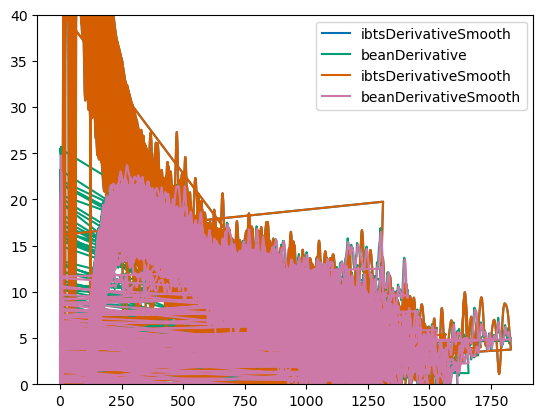

In [8]:
###roast phases###  - next work in progress
## Drying, Browning, and Development are not ideal, 
## because the bean is still drying after yellowing, still browning after FC, and certainly developing before FC
## thus I'm lableing phases Pre-YP, Pre-FC, Post-FC (let me know if you see other standards)
# April 23 kinda pissed that I lost the code that did this, but now I have copilot to help me rebuild it

# I already have turningPointTime	yellowPointTime	firstCrackTime
# Create a column for the time from start to Turning Point
### Finish creating some but not all of these new features 
### Times, Peak ROR, and average ROR slope for - TP, Drying Phase, Browning Phase, Development Phase

#this isn't working creat with copilot
# For each roast name in the point_df create a feature for peak ROR between TP and YP, these should match on roast names
#for i in point_df[roastName]
#point_df['DryingPhase-PeakROR'] = curve_df.loc[(curve_df.indexTime > point_df.indexTurningPoint) & (curve_df.indexTime < point_df.indexYellowingStart)].ibtsDerivative.max()

#smooth the beanDerivative at some rolling window. (this will later help me find the peak ROR in each phase. probably will also help to create a smoother 2nd derivative)
def smoother(df, column, window):
    df[column+'Smooth'] = df[column].rolling(window).mean()
    return df
smoother(curve_df, 'beanDerivative', 5)
smoother(curve_df, 'ibtsDerivative', 5)

# plot the smoothed curves with the original curves
# adjust axis limits to fit the data
def plotter(df, columns, window):
    for column in columns:
        plt.plot(df.indexTime, df[column], label=column)
    
    plt.ylim(0, 40) # set y-axis limits to 0 and 40
    plt.legend()
    plt.show()


plotter(curve_df, ['ibtsDerivativeSmooth', 'beanDerivative', 'ibtsDerivativeSmooth', 'beanDerivativeSmooth'], 5)



In [13]:
#smooth the beanDerivative at some rolling window. (this will later help me find the peak ROR in each phase. probably will also help to create a smoother 2nd derivative)
def smoother(df, column, window):
    df[column+'Smooth'+str(window)] = df[column].rolling(window).mean()
    print (f"created {column+'Smooth'+str(window)}")
    return df

# plot the smoothed curves with the original curves
# adjust axis limits to fit the data
def plot_curve(df, roast_name, columns):
    plot_df = df[df['roastName']==roast_name]
    for column in columns:
        plt.plot(plot_df.indexTime, plot_df[column], label=column)
    
    plt.ylim(0, 40) # set y-axis limits to 0 and 40
    plt.legend()
    plt.show()

# smooth the data
smoother(curve_df, 'beanDerivative', 30)
smoother(curve_df, 'beanDerivative', 40)
smoother(curve_df, 'beanDerivative', 60)
smoother(curve_df, 'ibtsDerivative', 60)
smoother(curve_df, 'ibtsDerivative', 80)
smoother(curve_df, 'ibts2ndDerivative', 100)
smoother(curve_df, 'beanDerivativeSmooth60', 60)


created beanDerivativeSmooth30
created beanDerivativeSmooth40
created beanDerivativeSmooth60
created ibtsDerivativeSmooth60
created ibtsDerivativeSmooth80
created ibts2ndDerivativeSmooth100
created beanDerivativeSmooth60Smooth60


,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,roastName,indexTime,softwareVersion,ibts2ndDerivative,beanDerivativeSmooth,ibtsDerivativeSmooth,beanDerivativeSmooth30,beanDerivativeSmooth40,beanDerivativeSmooth60,ibtsDerivativeSmooth60,ibtsDerivativeSmooth80,ibts2ndDerivativeSmooth100,beanDerivativeSmooth60Smooth100,bean2ndDerivative_from_Smooth60_np,bean2ndDerivative_from_Smooth60_npSmooth40,beanDerivativeSmooth60Smooth60
0,125.9,237.7,18.7,NaN,First Post-seasoning,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126.1,237.6,17.6,NaN,First Post-seasoning,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,126.2,237.9,16.1,NaN,First Post-seasoning,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,126.3,238.0,14.3,NaN,First Post-seasoning,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,126.4,237.3,12.8,NaN,First Post-seasoning,4,NaN,NaN,15.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153019,199.2,206.9,5.1,-0.8,#130 - Ethiopia Crown Jewel,969,3.4.1,-0.1,4.48,-0.52,4.536667,5.4050,6.313333,3.971667,4.1425,-0.086,10.161567,-0.067500,-0.092562,9.068861
153020,199.2,206.9,5.5,-0.8,#130 - Ethiopia Crown Jewel,970,3.4.1,0.0,4.84,-0.64,4.490000,5.3375,6.248333,3.856667,4.0475,-0.086,10.108350,-0.066667,-0.091896,8.984528
153021,199.3,206.9,5.5,-0.6,#130 - Ethiopia Crown Jewel,971,3.4.1,0.2,5.10,-0.72,4.463333,5.2650,6.180000,3.726667,3.9625,-0.081,10.054150,-0.066667,-0.091375,8.899667
153022,199.3,206.9,5.9,-0.6,#130 - Ethiopia Crown Jewel,972,3.4.1,0.0,5.36,-0.70,4.470000,5.2025,6.115000,3.596667,3.8775,-0.081,9.999033,-0.065000,-0.090917,8.814194


In [12]:
import numpy as np
curve_df['bean2ndDerivative_from_Smooth60_np'] = np.gradient(curve_df['beanDerivativeSmooth60'], curve_df['indexTime'])

#curve_df['bean2ndDerivative_fromSmooth60'] = curve_df.groupby('roastName')['beanDerivativeSmooth60'].apply(lambda x:x.diff())
smoother(curve_df, 'bean2ndDerivative_from_Smooth60_np', 40)
smoother(curve_df, 'bean2ndDerivative_from_Smooth60_np', 60)

created bean2ndDerivative_from_Smooth60_npSmooth40


KeyError: 'bean2ndDerivative_from_Smooth60'

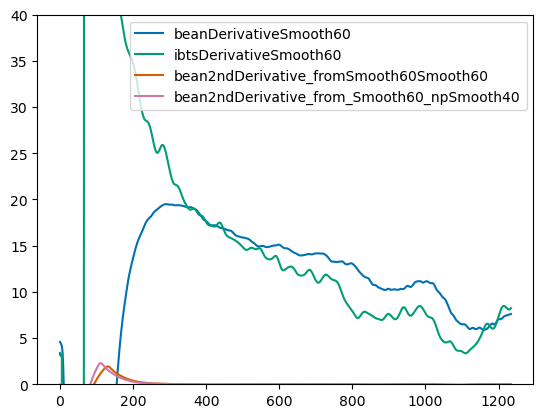

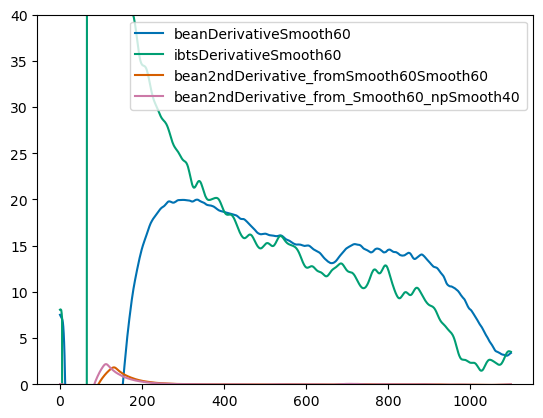

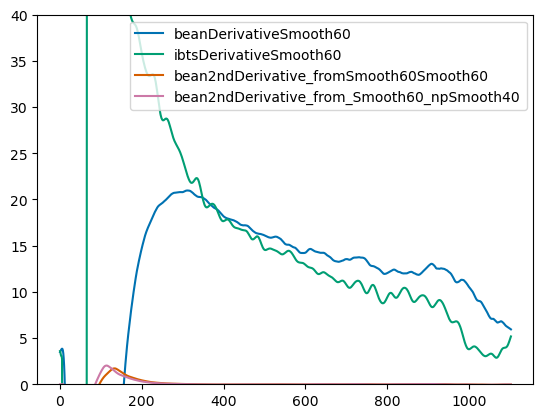

In [ ]:
# plot the data for the last n roasts
last_roasts = curve_df['roastName'].unique()[-3:]
for roast_name in last_roasts:
    plot_curve(curve_df, roast_name, ['beanDerivativeSmooth60', 'ibtsDerivativeSmooth60','bean2ndDerivative_fromSmooth60Smooth60','bean2ndDerivative_from_Smooth60_npSmooth40'])


created bean2ndDerivative_from_Smooth60_npSmooth40


,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,roastName,indexTime,softwareVersion,ibts2ndDerivative,beanDerivativeSmooth30,beanDerivativeSmooth40,beanDerivativeSmooth60,ibtsDerivativeSmooth60,ibtsDerivativeSmooth80,ibts2ndDerivativeSmooth100,ibts2ndDerivative_fromSmooth60,ibts2ndDerivative_fromSmooth60Smooth80,bean2ndDerivative_fromSmooth60,bean2ndDerivative_fromSmooth60Smooth80,bean2ndDerivative_fromSmooth60Smooth60,bean2ndDerivative_from_Smooth60_np,bean2ndDerivative_from_Smooth60_npSmooth80,bean2ndDerivative_from_Smooth60_npSmooth40
0,125.9,237.7,18.7,NaN,First Post-seasoning,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126.1,237.6,17.6,NaN,First Post-seasoning,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,126.2,237.9,16.1,NaN,First Post-seasoning,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,126.3,238.0,14.3,NaN,First Post-seasoning,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,126.4,237.3,12.8,NaN,First Post-seasoning,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150047,205.0,210.1,5.9,10.5,#126 - Ethiopia Crown Jewels Natural Wengo,1099,3.4.1,1.2,6.016667,5.9300,6.071667,4.650000,3.98375,0.053,-0.031667,-0.038729,-0.031667,-0.038729,-0.036250,-0.032500,-0.038615,-0.025854
150048,205.0,210.1,5.9,10.5,#126 - Ethiopia Crown Jewels Natural Wengo,1100,3.4.1,0.0,6.023333,5.8975,6.038333,4.780000,4.10250,0.053,-0.033333,-0.038500,-0.033333,-0.038500,-0.035472,-0.032500,-0.038437,-0.026187
150049,205.1,210.3,6.0,11.0,#126 - Ethiopia Crown Jewels Natural Wengo,1101,3.4.1,0.5,6.016667,5.8825,6.006667,4.915000,4.22875,0.050,-0.031667,-0.038375,-0.031667,-0.038375,-0.034750,-0.032500,-0.038448,-0.026146
150050,205.1,210.3,5.7,11.0,#126 - Ethiopia Crown Jewels Natural Wengo,1102,3.4.1,0.0,5.983333,5.8775,5.973333,5.050000,4.35500,0.050,-0.033333,-0.038521,-0.033333,-0.038521,-0.034111,-0.031667,-0.038615,-0.025979


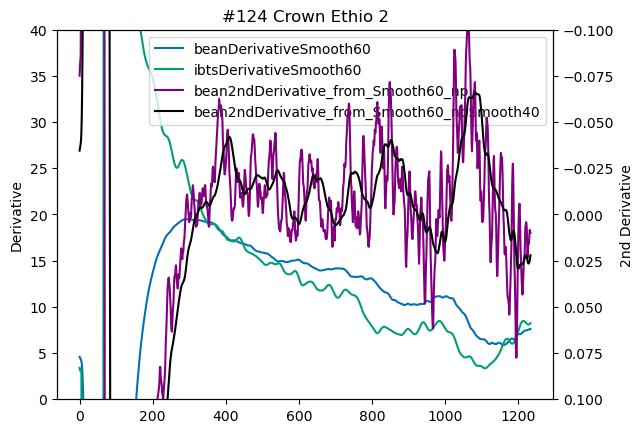

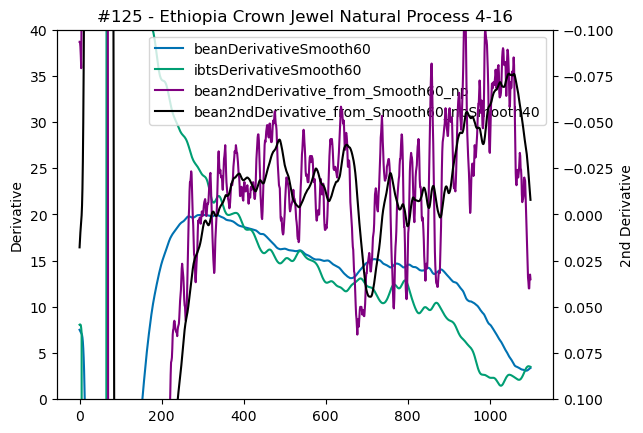

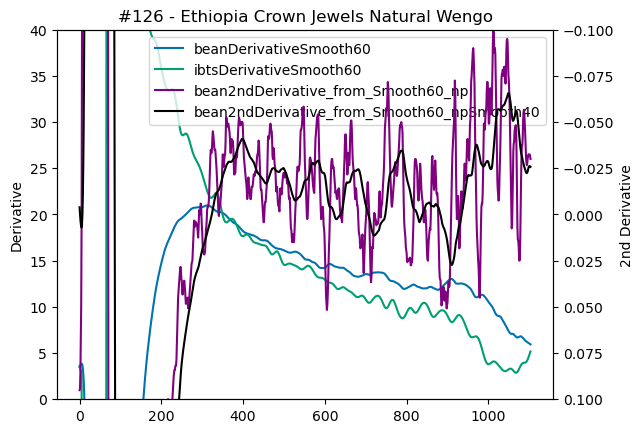

In [ ]:
# define function to plot curves
def plot_curve(df, roast_name, columns):
    fig, ax1 = plt.subplots()
    
    # plot derivative curves on left y-axis
    for column in columns:
        if '2ndDerivative' not in column:
            ax1.plot(df.loc[df['roastName']==roast_name, 'indexTime'], df.loc[df['roastName']==roast_name, column], label=column)
            
    # set left y-axis limits
    ax1.set_ylim(0, 40)
    ax1.set_ylabel('Derivative')
    
    # plot 2nd derivative curves on right y-axis
    ax2 = ax1.twinx()
    
    ax2.plot(df.loc[df['roastName']==roast_name, 'indexTime'], df.loc[df['roastName']==roast_name, 'bean2ndDerivative_from_Smooth60_np'], label='bean2ndDerivative_from_Smooth60_np', color='purple')
    ax2.plot(df.loc[df['roastName']==roast_name, 'indexTime'], df.loc[df['roastName']==roast_name, 'bean2ndDerivative_from_Smooth60_npSmooth40'], label='bean2ndDerivative_from_Smooth60_npSmooth40', color='black')
            
    # set right y-axis limits
    ax2.set_ylim(.1, -.1)
    #ax2.set_yscale('log')
    ax2.set_ylabel('2nd Derivative')
    
    # add legend
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1+handles2, labels1+labels2, loc='upper right')
    
    # show plot
    plt.title(roast_name)
    plt.show()
    

# plot the data for the last n roasts
last_roasts = curve_df['roastName'].unique()[-3:]
for roast_name in last_roasts:
    plot_curve(curve_df, roast_name, ['beanDerivativeSmooth60', 'ibtsDerivativeSmooth60', 'bean2ndDerivative_fromSmooth60','bean2ndDerivative_from_Smooth60_npSmooth40'])


In [ ]:
#started working on a function to create a centered rolling window but this will link together roasts, so I need to figure out how to do it by roast.
def centered_rolling_window(df, column, window):
    half_window = window // 2  # integer division to get half of the window size
    
    # Create a new column for the smoothed data
    smoothed_col = f"{column}Smooth{window}"
    df[smoothed_col] = np.nan
    
    # Loop through the dataframe, applying the rolling mean to each row
    for i in range(len(df)):
        start_idx = max(0, i - half_window)
        end_idx = min(len(df), i + half_window + 1)
        df.loc[i, smoothed_col] = df.iloc[start_idx:end_idx][column].mean()
    
    print(f"Created {smoothed_col} using a centered rolling window of size {window}")
    return df
centered_rolling_window(curve_df, 'bean2ndDerivative_from_Smooth60_np', 70)


Created bean2ndDerivative_from_Smooth60_npSmooth70 using a centered rolling window of size 70


,beanTemperature,drumTemperature,beanDerivative,ibtsDerivative,roastName,indexTime,softwareVersion,ibts2ndDerivative,beanDerivativeSmooth30,beanDerivativeSmooth40,beanDerivativeSmooth60,ibtsDerivativeSmooth60,ibtsDerivativeSmooth80,ibts2ndDerivativeSmooth100,ibts2ndDerivative_fromSmooth60,ibts2ndDerivative_fromSmooth60Smooth80,bean2ndDerivative_fromSmooth60,bean2ndDerivative_fromSmooth60Smooth80,bean2ndDerivative_fromSmooth60Smooth60,bean2ndDerivative_from_Smooth60_np,bean2ndDerivative_from_Smooth60_npSmooth80,bean2ndDerivative_from_Smooth60_npSmooth40,bean2ndDerivative_from_Smooth60_npSmooth70
0,125.9,237.7,18.7,NaN,First Post-seasoning,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,126.1,237.6,17.6,NaN,First Post-seasoning,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,126.2,237.9,16.1,NaN,First Post-seasoning,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,126.3,238.0,14.3,NaN,First Post-seasoning,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,126.4,237.3,12.8,NaN,First Post-seasoning,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150047,205.0,210.1,5.9,10.5,#126 - Ethiopia Crown Jewels Natural Wengo,1099,3.4.1,1.2,6.016667,5.9300,6.071667,4.650000,3.98375,0.053,-0.031667,-0.038729,-0.031667,-0.038729,-0.036250,-0.032500,-0.038615,-0.025854,-0.025750
150048,205.0,210.1,5.9,10.5,#126 - Ethiopia Crown Jewels Natural Wengo,1100,3.4.1,0.0,6.023333,5.8975,6.038333,4.780000,4.10250,0.053,-0.033333,-0.038500,-0.033333,-0.038500,-0.035472,-0.032500,-0.038437,-0.026187,-0.025256
150049,205.1,210.3,6.0,11.0,#126 - Ethiopia Crown Jewels Natural Wengo,1101,3.4.1,0.5,6.016667,5.8825,6.006667,4.915000,4.22875,0.050,-0.031667,-0.038375,-0.031667,-0.038375,-0.034750,-0.032500,-0.038448,-0.026146,-0.024693
150050,205.1,210.3,5.7,11.0,#126 - Ethiopia Crown Jewels Natural Wengo,1102,3.4.1,0.0,5.983333,5.8775,5.973333,5.050000,4.35500,0.050,-0.033333,-0.038521,-0.033333,-0.038521,-0.034111,-0.031667,-0.038615,-0.025979,-0.024077


In [ ]:


#will work on this later
#point_df['pre-YellowPointPhase'] = 
#point_df['pre-FirstCrackPhase'] = 
#point_df['post-FirstCrackPhase'] = 
# Development Time Ratio (DTR)
#point_df['DTR'] = 

#plot a histogram of DryingPhase-PeakROR
#fig.hist(point_df['DryingPhase-PeakROR'], bins=20, color='c', edgecolor='k', alpha=0.65)
#show.fig()


#display(point_df)

AttributeError: 'Figure' object has no attribute 'hist'

In [ ]:
#####################################     
##  Save transformed data to .csv  ##
#####################################

#create subfolder if needed
subfolder = 'csvExports/'
if not os.path.exists(subfolder):
    os.makedirs(subfolder)

now = datetime.now()
currentDateTime = now.strftime("%Y-%m-%d_%H%-M")

df.to_csv(subfolder + r'df_bulkData_' + currentDateTime + '.csv')   # may need   , index=False)
curve_df.to_csv(subfolder + r'curve_df_' + currentDateTime + '.csv')
point_df.to_csv(subfolder + r'point_df_' + currentDateTime + '.csv')

display ('Data frames saved in /' + subfolder + ' folder with current Date_Time ' + currentDateTime)

'Data frames saved in /csvExports/ folder with current Date_Time 2023-04-23_224'

### ----------------
### BREAK HERE: LOAD AND TRANSFORM ABOVE - VIEW AND ANALYZE BELOW
### ----------------

## will work through the below and figure out how to work it as seperate files/notebooks

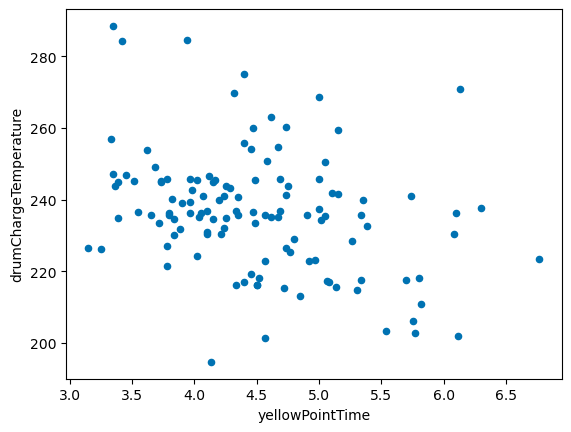

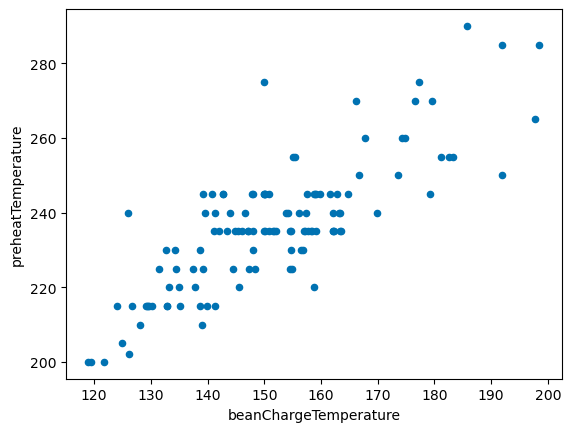

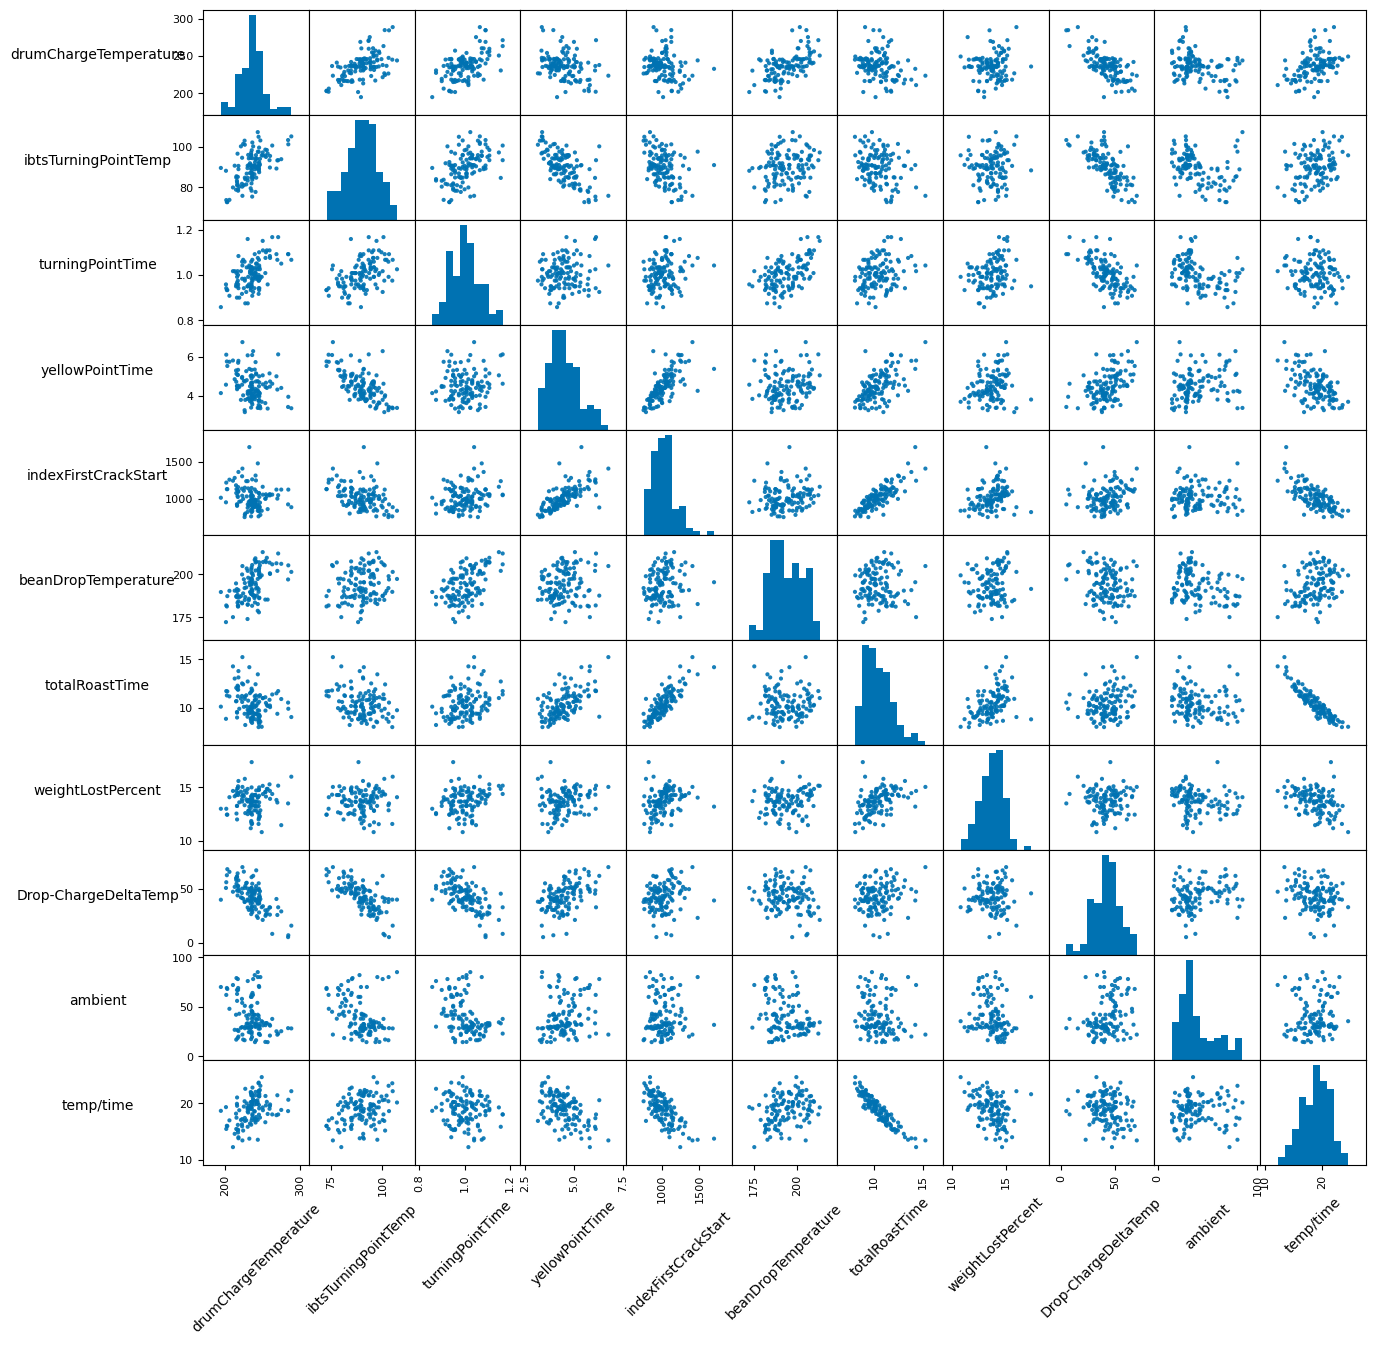

In [14]:
#####################    playing around with plot types and early observations as I learn
## Plot points_df  ##
#####################
# Bar Plot example
#point_df.plot.bar(x='roastName', y=["preheatTemperature","beanDropTemperature"])

# Box Plot example
#point_df['ibtsTurningPointTemp'].plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)

# PH to yellowing pt relation
point_df.plot.scatter(x='yellowPointTime', y='drumChargeTemperature')  #['indexYellowingStart', 'indexFirstCrackStart', 'roastEndIndex'])
# shows errors in recording actualy preheat temp (or charging too early)
point_df.plot.scatter(x='beanChargeTemperature', y='preheatTemperature') 

# difference between thermal probes
#point_df.plot.scatter(x= 'beanChargeTemperature', y='drumChargeTemperature')  
plt.show()

# colored scatter example
#iFCS = point_df['indexFirstCrackStart']/120
#plt.scatter(iFCS, point_df['drumChargeTemperature'], 
#            s=point_df['drumDropTemperature'], c=point_df['roastEndIndex'], alpha=0.5)
#plt.xlabel('First Crack Start (mins)')
#plt.ylabel('Preheat Temp (℃)')
#plt.show()

# Scatter Matrix 
from pandas.plotting import scatter_matrix 

# selecting  numerical features # Edit these to plot something differetn
features = [ 'drumChargeTemperature', 'ibtsTurningPointTemp', 'turningPointTime', 'yellowPointTime',
            'indexFirstCrackStart', 'beanDropTemperature','totalRoastTime','weightLostPercent',
            'Drop-ChargeDeltaTemp', 'ambient', 'temp/time']
sm = scatter_matrix(point_df[features], range_padding= .5, alpha = .9, figsize=(15,15))
[s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

plt.show() 

In [15]:
######################################################
## finding outliers and specific roasts from above  ##
######################################################

display (df.loc[(df.weightLostPercent > 20),['roastName', 'weightGreen', 'weightRoasted', 'weightLostPercent']])

# call out roasts in one region  #TO DO - make a region review variable
print ('\n kenyans')
for n in point_df.roastName:
    if n.__contains__("kenya") or n.__contains__("Kenya"):
        print (n)
        
# review roasts that are less than 8 mins - suspect that they are just roasting goof ups
print ('\n short roasts, less than 8 min')   
display (point_df.loc[(point_df.totalRoastTime) < 8,['roastName','totalRoastTime']])

# review roasts where the pre-heat temp was recorded to anything higher than I ever PH at
print ('\n high pre-heat outliers')   
display (point_df.loc[(point_df.preheatTemperature) > 290,['roastName', 'preheatTemperature','drumChargeTemperature']])

# sometimes the drumChargeTemperature is reading something lower than what the pre-heat was set at
# either because you started the roast without hitting the proper pre-heat or some other error
print ('\n charge temp  < 205 C')
display (point_df.loc[(point_df.drumChargeTemperature) < 205,['roastName', 'preheatTemperature','drumChargeTemperature']])

# Looking for errors or bad roasts with low drop temps
print ('\n low bean drop temp C')   #TO DO I need to be more specific at what/why I'm calling these outliners
display (point_df.loc[(point_df.drumDropTemperature) < 185,['roastName','drumDropTemperature','beanDropTemperature', 'totalRoastTime',
                                                            'comments', ]])

,roastName,weightGreen,weightRoasted,weightLostPercent



 kenyans
#13 Kenya Nyeri Githiru AA
# 25 Kenya Mix 350/140
# 25 Kenya Mix 350/140
#33 Kenya Gakuyu-Ini AA
#34 Kenya - Soak and watch
#35 Kenya no soak - FC stall, balls
#37 Kenya - fast start. always stalls
#44 Kenya - Rao suggestion
#45 Kenya Rao's with little to no fan. still crashed 40s after FC
#48 Kenya - dip to fix crash
#49 Kenya playback
#50 Kenya Recipie off 48

 short roasts, less than 8 min


,roastName,totalRoastTime



 high pre-heat outliers


,roastName,preheatTemperature,drumChargeTemperature



 charge temp  < 205 C


,roastName,preheatTemperature,drumChargeTemperature
9,#11 Ethiopia Agaro Nano Challa w/ Rob,200,201.5
16,#21 Ethiopia Genji Challa,202,201.9
21,# 25 Kenya Mix 350/140,200,202.7
22,# 25 Kenya Mix 350/140,200,203.3
25,#29 Genji Challa DP - Good,245,194.7



 low bean drop temp C


,roastName,drumDropTemperature,beanDropTemperature,totalRoastTime,comments
